In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target_dir = "./output/"
episodes = pd.read_csv(target_dir+"episodes.csv")
series = pd.read_csv(target_dir+"series.csv")
seasons = pd.read_csv(target_dir + "seasons.csv")
popular = pd.read_csv(target_dir + "popular.csv")
popular['rank'] = 1
popular['rank'] = popular['rank'].cumsum()

In [3]:
for i in ['free_available_date', 'availability_starts', 'availability_ends', 'upload_date', 'premium_available_date', 'episode_air_date']:
    episodes[i] = pd.to_datetime(episodes[i], errors='coerce', utc = True)

for i in ['up', 'down']:
    episodes[f'{i}_unit'].fillna("",inplace = True)
    episodes[f'{i}_displayed'] = episodes[f'{i}_displayed'].astype(str) + episodes[f'{i}_unit']
    episodes[f'{i}'] = episodes[f'{i}_displayed'].apply(lambda x: float(x[:-1]) * 1000 if x[-1] == 'K' else float(x) )


### Comments VS Rating on Audience Response System 

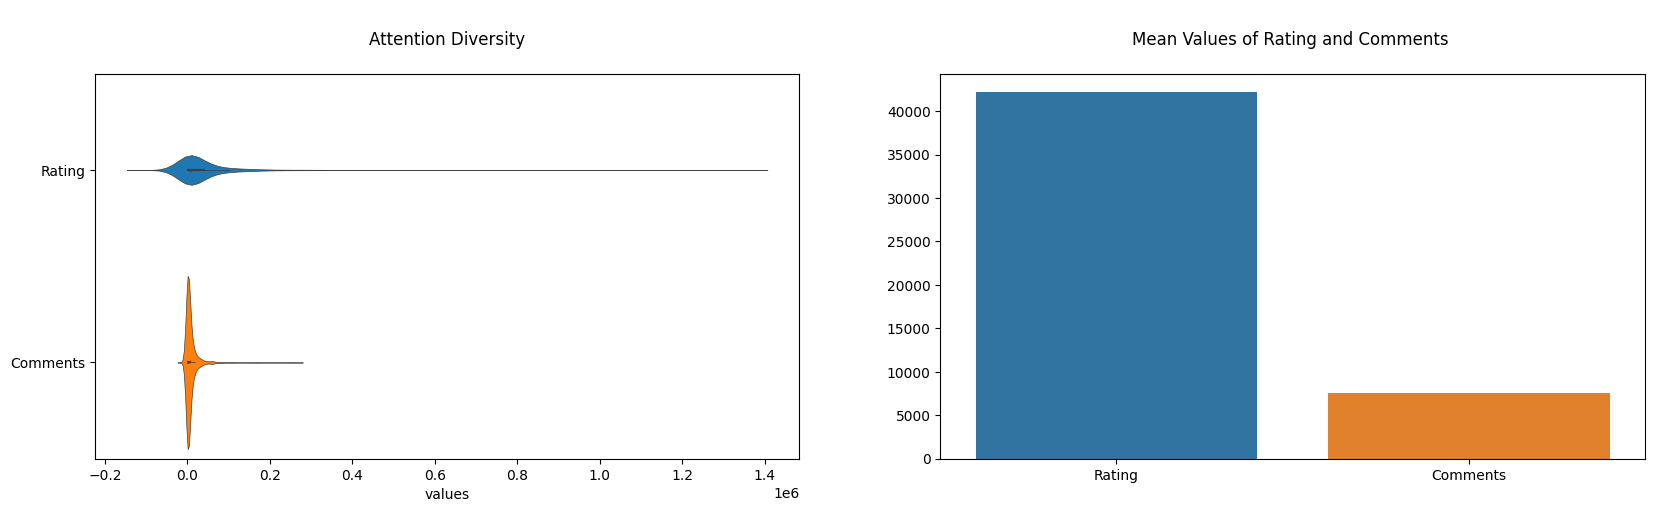

In [4]:
task1 = episodes.groupby('season_id').sum().loc[ :, ['rating_total', 'comments'] ].reset_index(drop=True)
task1.rename( {'rating_total': 'values', },axis=1,  inplace = True )
fig, axs = plt.subplots( figsize = (20, 5) , ncols=2)


task1['Type'] = 'Rating'
task1 = pd.concat( [task1.drop('comments',axis = 1), task1.drop( ['Type', 'values'], axis = 1 ).rename( {'comments': 'values', } , axis =1)  ] ,axis = 0 ).fillna('Comments')

sns.violinplot(data = task1, x = 'values', y = 'Type',saturation=1, width=0.9,cut =5, linewidth =0.5, ax = axs[0] )
sns.barplot( data = task1.groupby('Type').mean().reset_index(), y= 'values', x= 'Type', ax = axs[1], order = [ 'Rating', 'Comments' ] )

axs[0].set(title ="\nAttention Diversity\n",  ylabel = None)
axs[1].set(title = "\nMean Values of Rating and Comments \n", ylabel = None, xlabel =None )
plt.show()

##### Got insights of Audience Interaction Across Series 
- 4 times as Many Rating for Comments over the Series
- Obviously Rating less Work(effort) than Comments 

#### Paid VS Free Postive Rating rate

In [5]:
episodes['Positive rate'] = episodes['up'] / episodes['rating_total']
episodes['Negative rate'] = episodes['down'] / episodes['rating_total']

task_version = episodes.groupby('is_premium_only')[ ['Positive rate', 'Negative rate'] ].mean().rename( { True: ' Premium Episodes ', False : " FREE Episodes "}, axis = 0 )
task_version.index.rename(None, inplace= True)
display(task_version.sort_values( 'Positive rate', ascending = False ))
print()
print( "\tIt's Hard getting insights from imbalanced dataset " )
print( f"Total Counts of Premium episodes is {episodes.is_premium_only.sum()} and Free access episodes count is {len(episodes)-episodes.is_premium_only.sum()}" )

,Positive rate,Negative rate
FREE Episodes,0.971506,0.028590
Premium Episodes,0.969501,0.030333



	It's Hard getting insights from imbalanced dataset 
Total Counts of Premium episodes is 10843 and Free access episodes count is 1953


### WHich Series, Season, Episode got higher Positive Rating and Worst Rating 
- disclaimer :  Worst Rating isn't interesting as i thought so switch to worst rating rate ( negative rating / total )

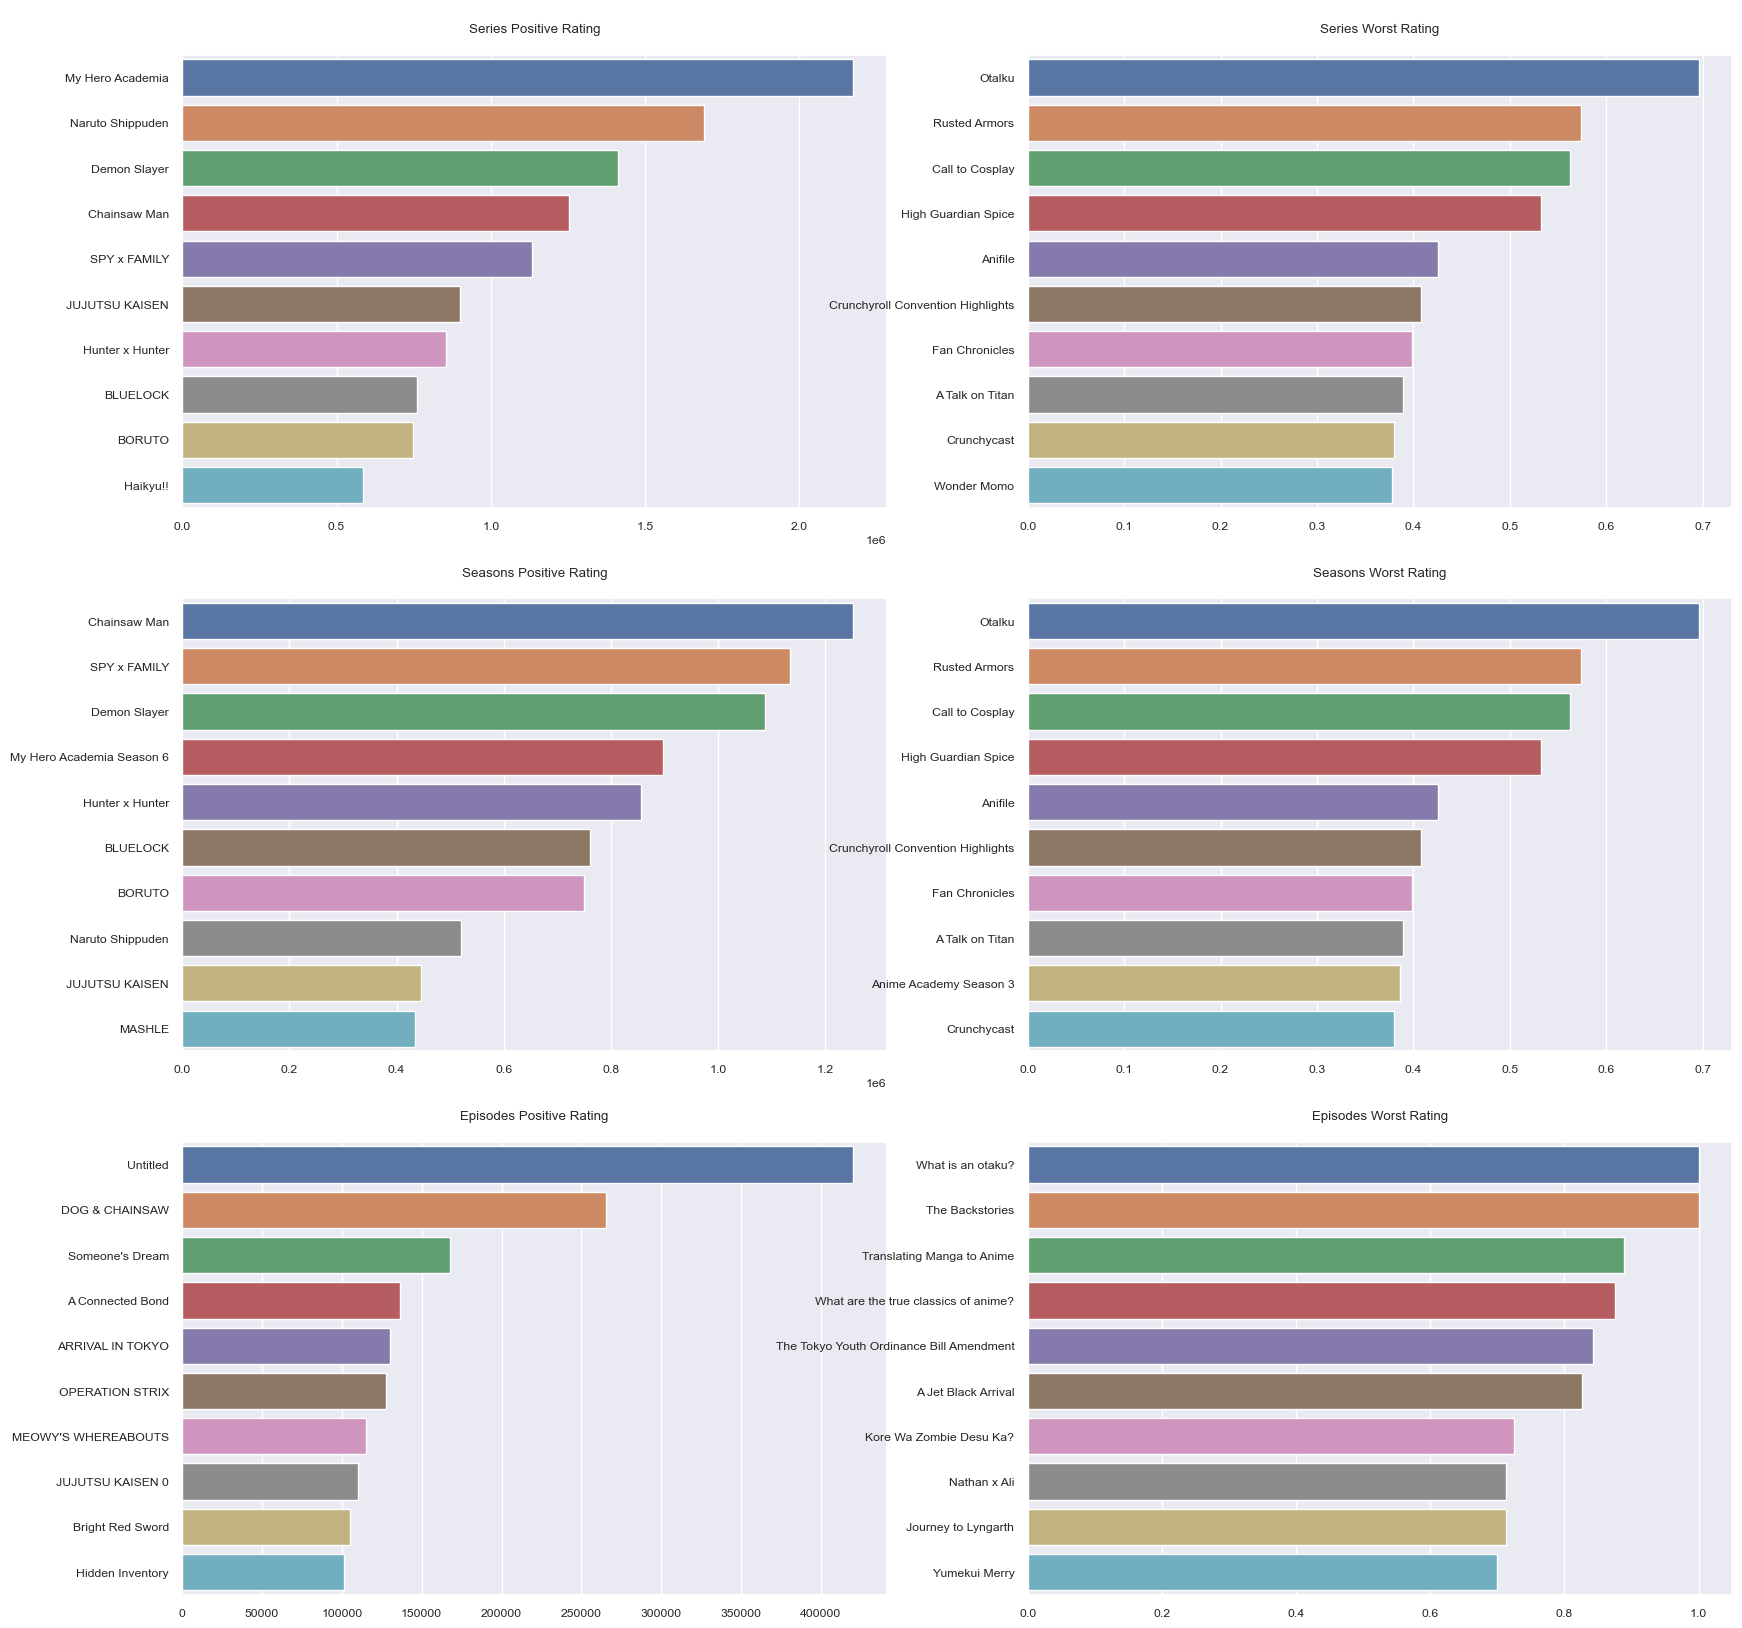

In [6]:
task2 = episodes.loc[:, [  'season_title','series_title','title', 'sequence_number', 'up', 'down' ]]

task2.fillna( "Unknown Title" , inplace= True)


series_task2 = task2.groupby('series_title')[['up', 'down']].sum().reset_index().rename( { 'series_title':"title" }, axis = 1 )
seasons_task2 = task2.groupby('season_title')[['up', 'down']].sum().reset_index().rename(  { 'season_title': 'title'}, axis = 1) 
episodes_task2 = task2.groupby('title')[['up', 'down']].sum().reset_index()
def calculate_rating( dataframe ):
    dataframe['title'] = dataframe.title.str.replace( r"\{.+\}|\(.+\)|\:.+|\-.+", '',regex = True )
    dataframe['total'] = dataframe['up']+ dataframe['down']
    dataframe['Positive Rate'] = dataframe['up'] / dataframe['total']
    dataframe['Negative Rate'] = 1 - dataframe['Positive Rate']
    return dataframe

series_task2 = calculate_rating(series_task2)
seasons_task2 = calculate_rating(seasons_task2)
episodes_task2 = calculate_rating(episodes_task2)
sns.set(font_scale = .8)
fig, axs = plt.subplots( figsize = (20, 20) , ncols=2, nrows=3)

sns.barplot( data = series_task2.sort_values( 'up', ascending = False ).head(10), x = 'up', y = 'title', ax = axs[0][0] )
sns.barplot( data = seasons_task2.sort_values( 'up', ascending = False ).head(10), x = 'up', y = 'title', ax = axs[1][0] )
sns.barplot( data = episodes_task2.sort_values( 'up', ascending = False ).head(10), x = 'up', y = 'title', ax = axs[2][0] )

sns.barplot( data = series_task2.sort_values( 'Negative Rate', ascending = False ).head(10), x = 'Negative Rate', y = 'title', ax = axs[0][1] )
sns.barplot( data = seasons_task2.sort_values( 'Negative Rate', ascending = False ).head(10), x = 'Negative Rate', y = 'title', ax = axs[1][1] )
sns.barplot( data = episodes_task2.sort_values( 'Negative Rate', ascending = False ).head(10), x = 'Negative Rate', y = 'title', ax = axs[2][1] )
for i,x in enumerate( [ 'Series', 'Seasons', 'Episodes' ] ):
    for j, y in enumerate([ "Positive Rating", 'Worst Rating' ]):
        axs[i][j].set( ylabel = None, xlabel =None, title = f"\n{x} {y}\n")


##### Result telling insights
- Here you can see Anime series related content ( review, behind scene, etc ) without Anime series itself was terrible in Audience perspective
- My hero Academia Series dominate over Series , Season, Episode Categories
- Many Worst Shows Rating from crunchyroll original Content

### Crunchyroll Over Years of Audience traffic
- disclaimer : We Don't have excact numbers so i took Episodes Rating in order of release date that have similar track with Traffic

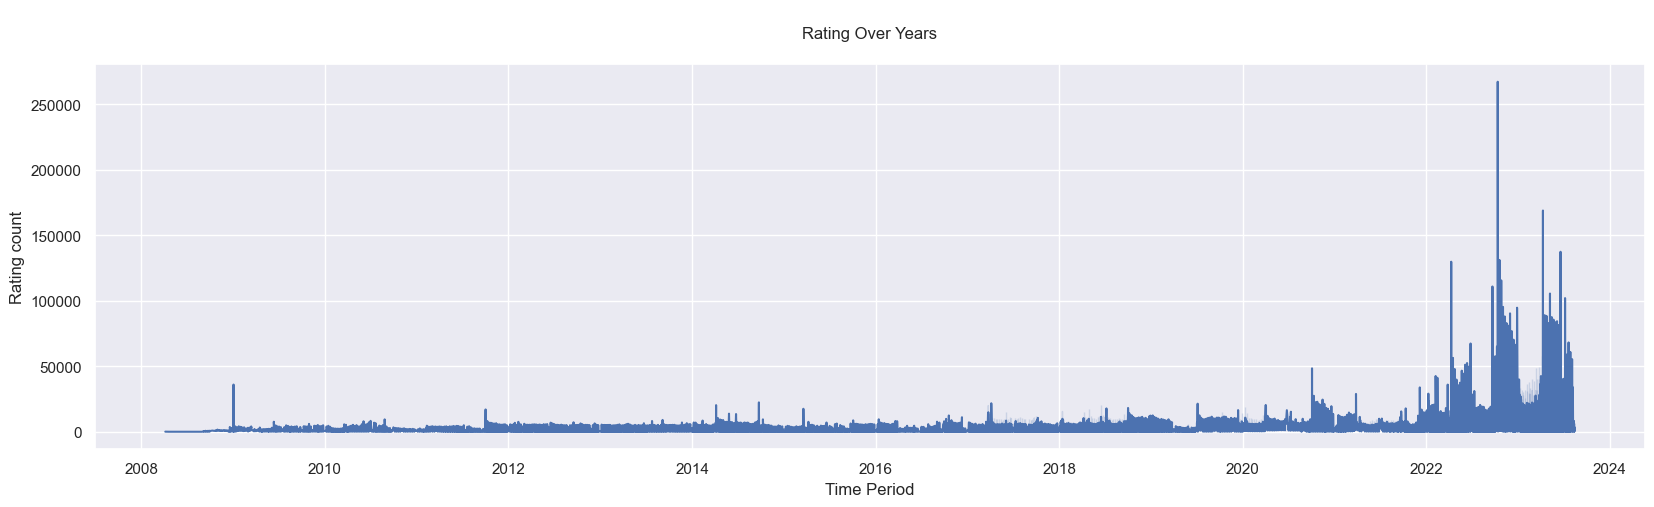

In [7]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,5)})
episodes.sort_values('upload_date', ascending =True, inplace= True)
chart = sns.lineplot( y = episodes['rating_total'], x  = episodes['upload_date'])
chart.set_title( '\nRating Over Years\n' )
chart.set_ylabel('Rating count')
chart.set_xlabel('Time Period')
plt.show()

### Top Rating Genres and Keywords 

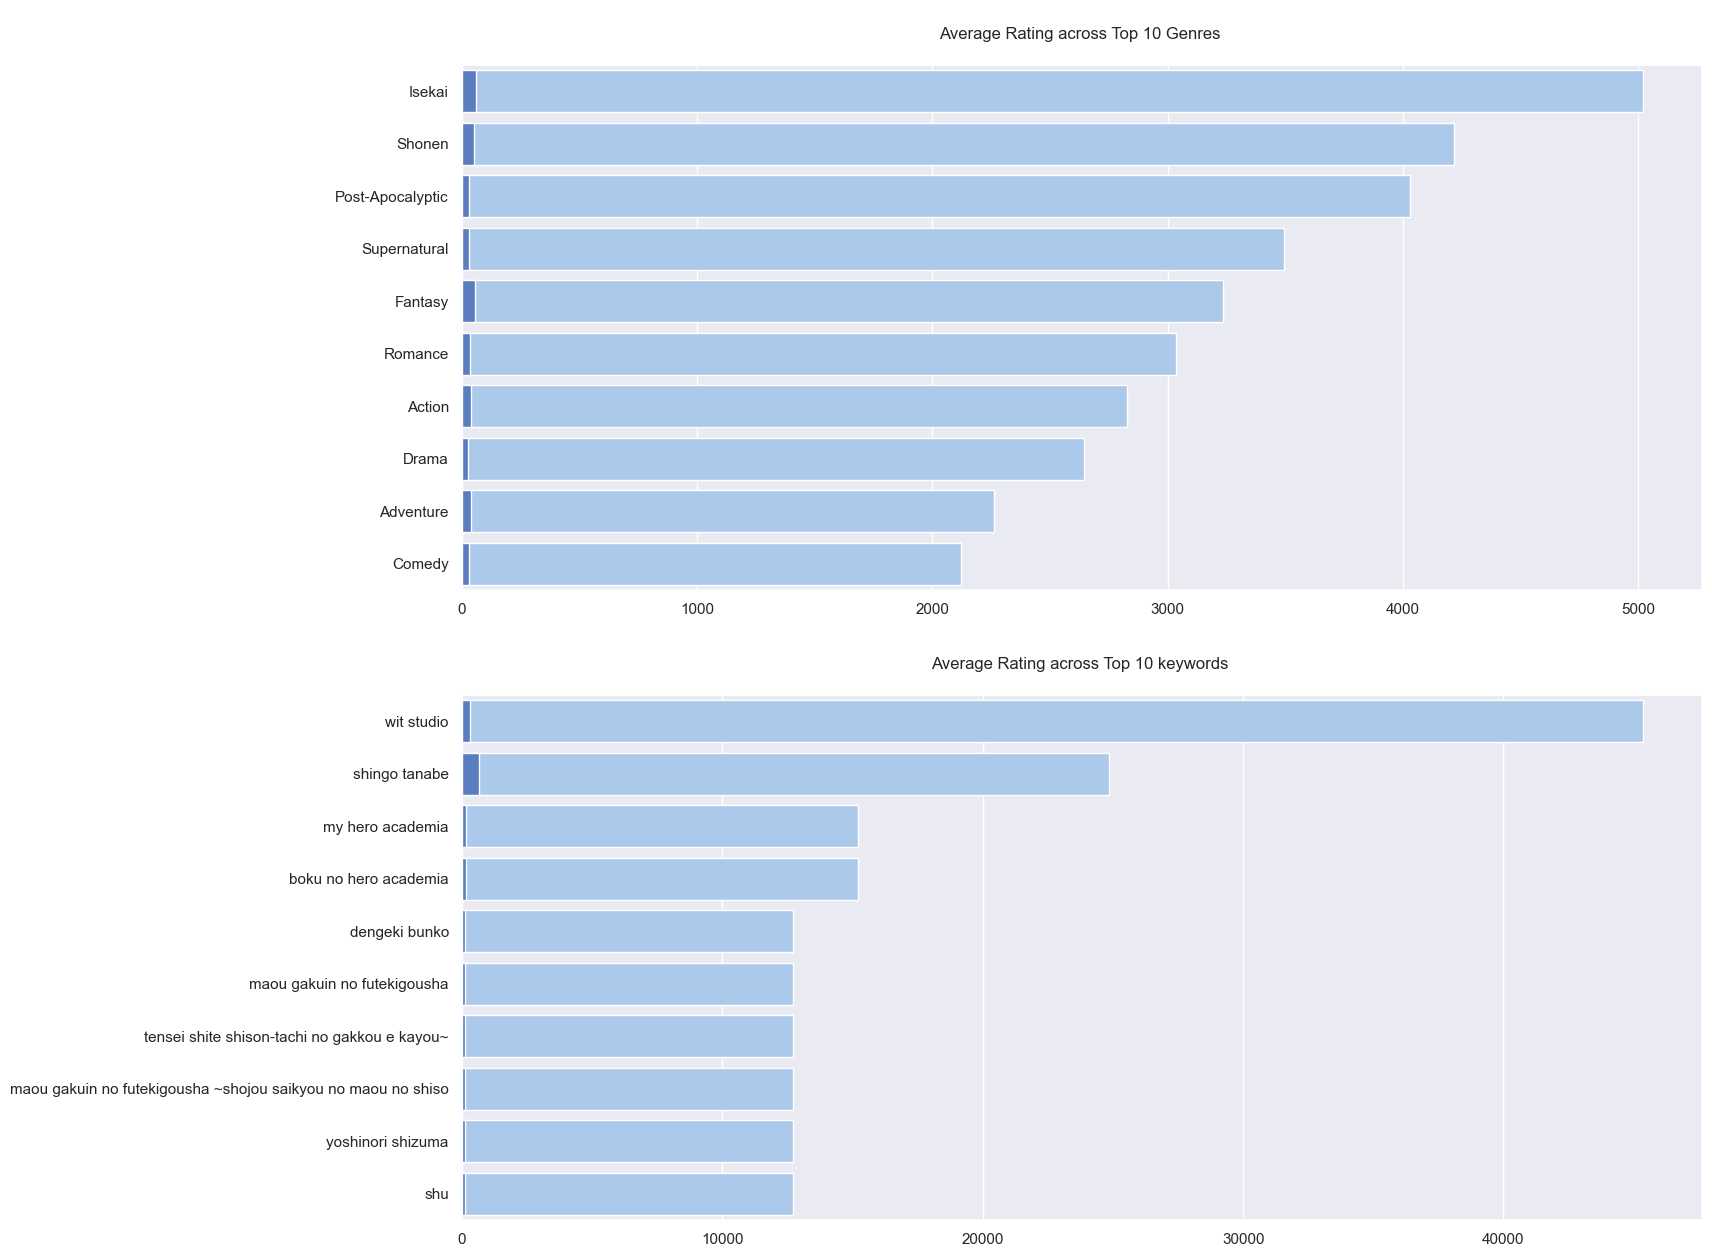

In [8]:

task_5 = episodes.loc[:, [ 'rating_total', 'up', 'down', 'series_id' ]].merge(
     popular.loc[popular.type == 'series', ['tenant_categories', 'id']].rename(columns = {'id':'series_id', 'tenant_categories':'categories'},errors = 'raise'), on = 'series_id',how ='left'  )

categories_stats = dict()
def get_rows_update(row):
    global categories_stats
    for i in row.categories.split(','):
        i = i.strip()
        try:
            categories_stats[i][0].append( row.up )
            categories_stats[i][1].append( row.down )
        except KeyError:
            categories_stats[i] = [ [row.up], [row.down] ]
task_5.dropna().apply(get_rows_update, axis =1)

keywords_stats = dict()
def get_rows_update(row):
    global keywords_stats
    for i in row.keywords.split(','):
        i = i.strip()
        try:
            keywords_stats[i][0].append( row.up )
            keywords_stats[i][1].append( row.down )
        except KeyError:
            keywords_stats[i] = [ [row.up], [row.down] ]

task_5 = episodes.loc[:, [ 'rating_total', 'up', 'down', 'series_id' ]].merge( series.loc[:, ['id', 'keywords'] ].rename(columns = {'id':'series_id'}), how = 'left', on ='series_id')
task_5.dropna().apply(get_rows_update, axis =1)

def get_mean_df( stats ):
    df = pd.DataFrame(stats).T.rename( columns = { 0: "Positive", 1 : "Negative" } )
    df['Positive'] = df['Positive'].apply( lambda x : sum(x) / len(x) )
    df['Negative'] = df['Negative'].apply( lambda x : sum(x) / len(x) )
    df.sort_values( 'Positive', ascending = False, inplace = True )
    return df.reset_index()

categories_df = get_mean_df(categories_stats).head(10)
keywords_df = get_mean_df(keywords_stats).head( 10 )

fig, axs = plt.subplots( figsize = (16, 15) , nrows=2)



# Plot the total Rating
sns.set_color_codes("pastel")
sns.barplot(x= 'Positive' , y= 'index' ,data = categories_df,
             color="b", ax = axs[0] )

sns.set_color_codes("muted")
sns.barplot(x= 'Negative' , y= "index", data = categories_df,
             color="b" ,ax = axs[0] )
axs[0].set( ylabel=None, xlabel = None,
      title="\nAverage Rating across Top 10 Genres \n")

# Plot the total Rating
sns.set_color_codes("pastel")
sns.barplot(x= 'Positive' , y= 'index' ,data = keywords_df,
             color="b", ax = axs[1] )

sns.set_color_codes("muted")
sns.barplot(x= 'Negative' , y= "index", data = keywords_df,
             color="b" ,ax = axs[1] )
axs[1].set( ylabel=None, xlabel = None,
      title="\nAverage Rating across Top 10 keywords \n")
plt.show()


##### Facts about Genres 
- Shonen shows got average 3 seasons, that reflect huge audience rating
- My Hero Academia got 6 season and 143 episodes yet that causes it keywords get huge count

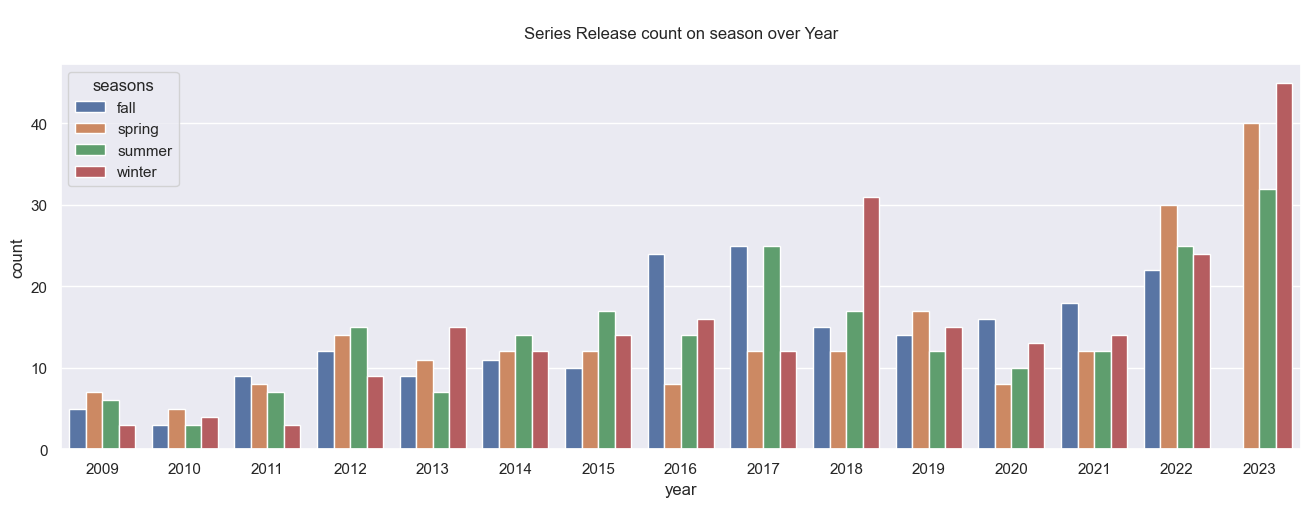

In [9]:
task6 = series.loc[ :, ['season_tags'] ]

season_tags = ','.join(task6.season_tags.fillna('').to_list())
season_tags = [ x for  x in  season_tags.split(',') if len(x)> 0]
del task6['season_tags']

fig, axs = plt.subplots( figsize = (16, 5) )
task6 = pd.DataFrame()
task6['season_tags'] = season_tags
task6['count'] = 1
# task6['count'] = task6['count'].cumsum()
task6['year'] = task6.season_tags.apply(lambda x : x.split('-')[1].strip())
task6['season_tags'] = task6.season_tags.apply(lambda x : x.split('-')[0].strip())
task6 = task6.groupby( ['year','season_tags'] ).sum().reset_index().rename( { "season_tags": "seasons" }, axis = 1 )

sns.barplot( data = task6, x = 'year', y= 'count', hue = 'seasons', ax = axs  )
axs.set( title = "\nSeries Release count on season over Year\n" )
plt.show()

#### Note
- Current year have missing some season due to it's completed

### Sub vs Dub Series
- Disclaimer : Subtitle series Based on episodes has one audio version and other series beyond to Dubbed Version Series

In [10]:
episodes['anime type'] = "Dubbed"
episodes.loc[ episodes.audio_versions == "ja-JP", 'anime type' ] = "Subbed"
task8 = episodes.groupby("anime type")[ ['Positive rate', 'Negative rate'] ].mean().sort_values( 'Positive rate', ascending = False )
display(task8)
print()
print(f" \t Based on Crunchyroll data, it's clear Winner {task8.iloc[0].name} Anime Series ")

,Positive rate,Negative rate
anime type,,
Dubbed,0.971250,0.028754
Subbed,0.968368,0.031376



 	 Based on Crunchyroll data, it's clear Winner Dubbed Anime Series 


### Ad Count corresponding to episode duration

<Axes: xlabel='ad_breaks_count', ylabel='duration'>

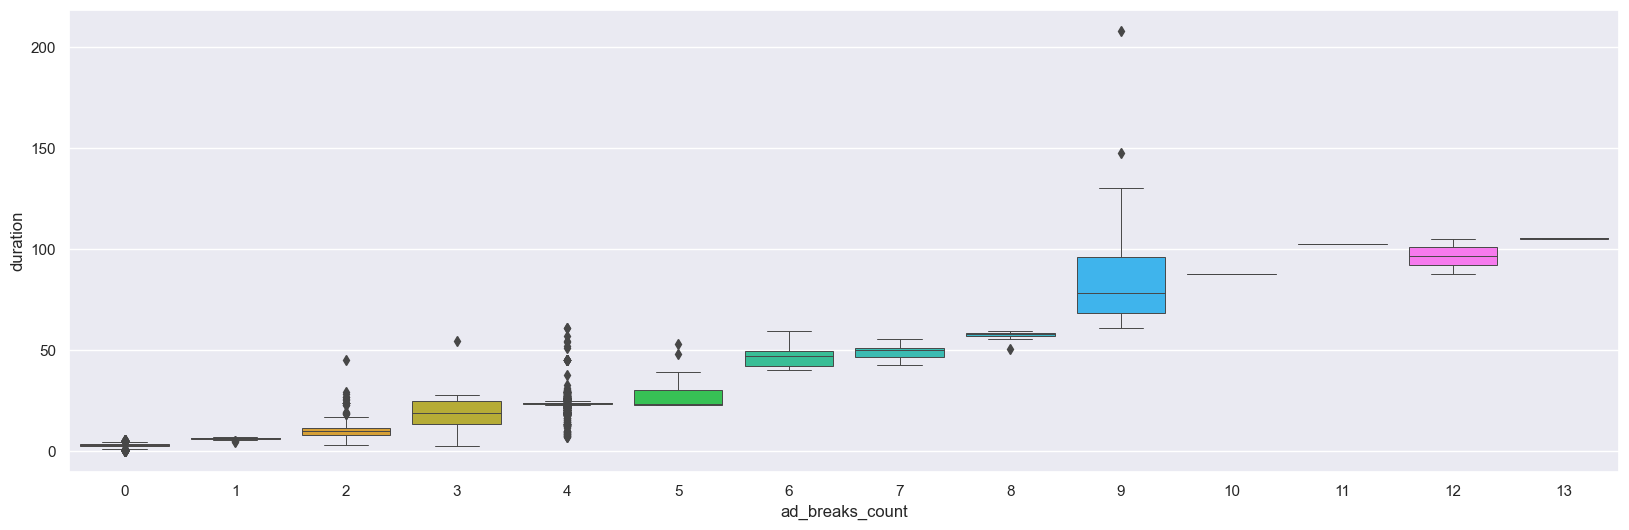

In [11]:
fig, axs = plt.subplots( figsize = (20, 6) )
task9 = episodes.loc[:, [ 'duration_ms', "ad_breaks_count" ]]
task9['duration'] = task9['duration_ms'] / 60000
sns.boxplot(data = task9, y= 'duration', x = 'ad_breaks_count',orient = "v", ax =axs, saturation=1, linewidth=0.7)

#### some Insights 
- Every 8 minutes, a individual ad pop out 
- huge amount of episodes fall into 4 ads category